In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=columns)
ratings.drop('timestamp', axis=1, inplace=True)

columns = ['item_id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=columns, encoding='latin-1')
movies = movies[['item_id', 'movie title']]

n_users = len(ratings['user_id'].unique())
n_items = len(movies['item_id'].unique())
rating_mat = np.zeros(shape= (n_users, n_items))

In [48]:
n_users

943

In [4]:
ratings.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
users = []
items = []
rating = []
for row in ratings.itertuples(index=False):
    users.append(row[0])
    items.append(row[1])
    rating.append(row[2])

In [6]:
K = 10
lr = 1e-3
batch_size= 128
epochs = 100

In [7]:
class MF(tf.keras.Model):
    def __init__(self, n_users, n_items, K=10):
        super(MF, self).__init__()

        self.u_embedding = tf.keras.layers.Embedding(n_users, K, name="user_embedding")
        self.i_embedding = tf.keras.layers.Embedding(n_items, K, name="item_embedding")
        self.flatten = tf.keras.layers.Flatten()
        self.predictor = tf.keras.layers.Dense(1, activation='relu')

    def call(self, input, training=False):
        u = self.u_embedding(input[0], training=training)
        i = self.i_embedding(input[1], training=training)

        u = self.flatten(u)
        i = self.flatten(i)

        x = tf.keras.layers.Dot(axes=1)([u, i])
        x = self.predictor(x , training=training)

        return x
    def model(self):
        user = tf.keras.layers.Input(shape=(1, ), name='user_input')
        item = tf.keras.layers.Input(shape=(1, ), name='item_input')

        return tf.keras.Model(inputs=[user, item], outputs=self.call([user, item]))

In [8]:
model = MF(n_users, n_items, K=K).model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        9430        ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        16820       ['item_input[0][0]']             
                                                                                              

In [125]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [10]:
ratings['ranked_itemId'] = stats.rankdata(ratings['item_id'], method='dense')-1

In [11]:
ratings.head()

,user_id,item_id,rating,ranked_itemId
0,196,242,3,241
1,186,302,3,301
2,22,377,1,376
3,244,51,2,50
4,166,346,1,345


In [12]:
real_to_ranked_itemId = {}
for i, content in ratings.iterrows():
    real_to_ranked_itemId[content['item_id']] = content['ranked_itemId']

In [13]:
real_to_ranked_itemId

{242: 241,
 302: 301,
 377: 376,
 51: 50,
 346: 345,
 474: 473,
 265: 264,
 465: 464,
 451: 450,
 86: 85,
 257: 256,
 1014: 1013,
 222: 221,
 40: 39,
 29: 28,
 785: 784,
 387: 386,
 274: 273,
 1042: 1041,
 1184: 1183,
 392: 391,
 486: 485,
 144: 143,
 118: 117,
 1: 0,
 546: 545,
 95: 94,
 768: 767,
 277: 276,
 234: 233,
 246: 245,
 98: 97,
 193: 192,
 88: 87,
 194: 193,
 1081: 1080,
 603: 602,
 796: 795,
 32: 31,
 16: 15,
 304: 303,
 979: 978,
 564: 563,
 327: 326,
 201: 200,
 1137: 1136,
 241: 240,
 4: 3,
 332: 331,
 100: 99,
 432: 431,
 322: 321,
 181: 180,
 196: 195,
 679: 678,
 384: 383,
 143: 142,
 423: 422,
 515: 514,
 20: 19,
 288: 287,
 219: 218,
 526: 525,
 919: 918,
 26: 25,
 232: 231,
 427: 426,
 512: 511,
 15: 14,
 1049: 1048,
 416: 415,
 165: 164,
 690: 689,
 248: 247,
 1444: 1443,
 5: 4,
 229: 228,
 237: 236,
 480: 479,
 54: 53,
 366: 365,
 518: 517,
 403: 402,
 111: 110,
 625: 624,
 338: 337,
 25: 24,
 1016: 1015,
 154: 153,
 275: 274,
 1153: 1152,
 498: 497,
 382: 381,


In [14]:
movies['ranked_itemId'] = movies['item_id'].map(real_to_ranked_itemId)

In [15]:
ratings['user_id'] = ratings['user_id'] - 1 # make id to start from 0

In [16]:
movies.dropna()

,item_id,movie title,ranked_itemId
0,1,Toy Story (1995),0
1,2,GoldenEye (1995),1
2,3,Four Rooms (1995),2
3,4,Get Shorty (1995),3
4,5,Copycat (1995),4
...,...,...,...
1677,1678,Mat' i syn (1997),1677
1678,1679,B. Monkey (1998),1678
1679,1680,Sliding Doors (1998),1679
1680,1681,You So Crazy (1994),1680


In [17]:
def get_dataset_partitions(df, train_split=0.8, val_split=0.1, test_split=0.1):
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split) * len(df))]
    train_df, val_df, test_df = np.split(df_sample, indices_or_sections)
    return train_df, val_df, test_df

In [18]:
train_df, val_df, test_df = get_dataset_partitions(ratings)

In [19]:
train_df.head()

,user_id,item_id,rating,ranked_itemId
23441,436,404,5,403
90125,12,813,1,812
57892,626,62,4,61
7228,150,223,5,222
99545,803,132,4,131


In [20]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0,
    patience=5,
    verbose=0,
    mode='auto',
    restore_best_weights=True
)

In [126]:
history = model.fit(
    x = [train_df['user_id'].values, train_df['ranked_itemId'].values],
    y = train_df['rating'].values,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([val_df['user_id'].values, val_df['ranked_itemId'].values],
                     val_df['rating'].values),
    callbacks=[early_stop_callback]
)

Epoch 1/100
625/625 [==============================] - 5s 6ms/step - loss: 1.2703 - root_mean_squared_error: 1.1271 - val_loss: 1.2540 - val_root_mean_squared_error: 1.1198
Epoch 2/100
625/625 [==============================] - 3s 6ms/step - loss: 1.2703 - root_mean_squared_error: 1.1271 - val_loss: 1.2540 - val_root_mean_squared_error: 1.1198
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2702 - root_mean_squared_error: 1.1270 - val_loss: 1.2543 - val_root_mean_squared_error: 1.1200
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2703 - root_mean_squared_error: 1.1271 - val_loss: 1.2540 - val_root_mean_squared_error: 1.1198
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2702 - root_mean_squared_error: 1.1271 - val_loss: 1.2541 - val_root_mean_squared_error: 1.1199
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2702 - root_mean_squared_error: 1.1270 - val_loss: 1.2541 

In [22]:
model.evaluate([val_df['user_id'], val_df['ranked_itemId']], val_df['rating'], batch_size=128, verbose=2)

79/79 - 0s - loss: 1.2540 - mse: 1.2540 - 498ms/epoch - 6ms/step


[1.254015564918518, 1.254015564918518]

In [23]:
model.evaluate([test_df['user_id'], test_df['ranked_itemId']], test_df['rating'], batch_size=128, verbose=2)

79/79 - 0s - loss: 1.2560 - mse: 1.2560 - 174ms/epoch - 2ms/step


[1.2560021877288818, 1.2560021877288818]

# Something using with the embeddings

In [37]:
movie_embedding_model = tf.keras.Model(inputs=model.get_layer('item_input').input, outputs = model.get_layer('item_embedding').output)
movie_embeddings = movie_embedding_model.predict(movies['ranked_itemId'])
movie_embeddings = movie_embeddings.reshape(len(movies), 10)

53/53 [==============================] - 0s 675us/step


In [64]:
user_id_list = np.sort(ratings['user_id'].unique())
print(user_id_list.shape)
user_id_list = np.expand_dims(user_id_list, 1)
print(user_id_list.shape)

(943,)
(943, 1)


In [66]:
movies['ranked_itemId'].shape

(1682,)

In [68]:
pred_model = tf.keras.Model(inputs=model.get_layer('user_input').input, outputs = model.get_layer('user_embedding').output)
pred = pred_model.predict(user_id_list)

30/30 [==============================] - 0s 722us/step


In [72]:
pred = pred.reshape(n_users, 10)
pred.shape

In [116]:
x = tf.matmul(pred, movie_embeddings, transpose_b=True)

In [120]:
user_195 = ratings.loc[ratings["user_id"] == 195].pivot_table('rating', index='user_id', columns='item_id')

In [121]:
np.array(x[195])[user_195.columns]

array([ 3.2298830e-03,  3.7745046e-03, -4.4286274e-04, -2.4183438e-04,
       -4.3022814e-03,  5.0310593e-04,  5.7645061e-04, -1.7308421e-04,
       -4.7843917e-03,  3.1654555e-03, -1.3112333e-03, -1.1006403e-03,
        2.7345435e-03, -1.4913690e-03,  2.6532388e-03,  6.1706570e-04,
        6.3912757e-04,  4.4263020e-04,  8.2273775e-04, -2.3993268e-03,
        4.7901319e-03, -1.2381643e-03, -1.1355884e-04, -3.6812644e-03,
       -4.0657155e-04,  5.7887990e-04,  1.1146816e-03, -7.1629940e-05,
        2.8749229e-05, -1.6659141e-03, -2.3951547e-03,  2.1847405e-03,
       -2.8129562e-03, -2.5003008e-04,  4.1458271e-03, -8.4723963e-04,
       -4.5075403e-03, -3.1003738e-03, -3.8351386e-03], dtype=float32)

In [114]:
out[195]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [40]:
from sklearn.cluster import KMeans

In [41]:
kluster = range(1, 10)

inertias = []
mapping = {}

for k in kluster:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(movie_embeddings)
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_

In [42]:
import matplotlib.pyplot as plt

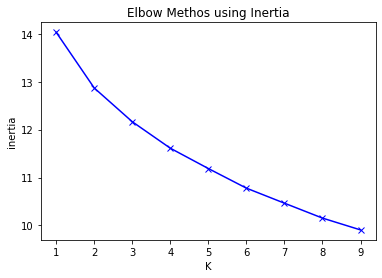

In [43]:
plt.plot(kluster, inertias, 'bx-')
plt.xlabel("K")
plt.ylabel("inertia")
plt.title("Elbow Methos using Inertia")
plt.show()

In [44]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(movie_embeddings)

In [73]:
for cluster in range(4):
    print("Cluster #{}".format(cluster))
    movies_list = []
    for movie_index in np.where(kmeans.labels_ == cluster)[0]:
        movie_name = movies.iloc[movie_index]['movie title']
        movie_id = movies.iloc[movie_index]['ranked_itemId']
        movie_rating_count = ratings.loc[ratings['ranked_itemId'] == movie_id].count()[0]
        movies_list.append((movie_name, movie_id, movie_rating_count))

    for movie in sorted(movies_list, key=lambda x:x[1], reverse=True)[:10]:
        print("\t", movie[0], ' - ', movie[2])

Cluster #0
	 Scream of Stone (Schrei aus Stein) (1991)  -  1
	 You So Crazy (1994)  -  1
	 Sliding Doors (1998)  -  1
	 Sweet Nothing (1995)  -  1
	 War at Home, The (1996)  -  1
	 Mamma Roma (1962)  -  1
	 Nothing Personal (1995)  -  1
	 Rough Magic (1995)  -  2
	 Small Faces (1995)  -  1
	 Little City (1998)  -  2
Cluster #1
	 MURDER and murder (1996)  -  1
	 Next Step, The (1995)  -  1
	 Ripe (1996)  -  1
	 New Age, The (1994)  -  1
	 Target (1995)  -  1
	 Favor, The (1994)  -  1
	 Temptress Moon (Feng Yue) (1996)  -  3
	 Big One, The (1997)  -  1
	 Men With Guns (1997)  -  2
	 Sudden Manhattan (1996)  -  2
Cluster #2
	 Sunchaser, The (1996)  -  1
	 Further Gesture, A (1996)  -  1
	 Tainted (1998)  -  1
	 Brother's Kiss, A (1997)  -  1
	 Substance of Fire, The (1996)  -  3
	 Entertaining Angels: The Dorothy Day Story (1996)  -  1
	 Butcher Boy, The (1998)  -  1
	 Eighth Day, The (1996)  -  1
	 Bitter Sugar (Azucar Amargo) (1996)  -  3
	 Brothers in Trouble (1995)  -  1
Cluster #3
	 

In [ ]:
test_user = np.zeros(n_users, 1)